# Telco Churn

## Imports and helpers

In [13]:
import os
from pathlib import Path
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import joblib

pd.set_option('display.max_columns', 200)
sns.set(style='whitegrid')

def data_path(fname='data/telco_raw.csv'):
    return Path.cwd() / fname

def set_seed(seed=42):
    np.random.seed(seed)

set_seed(42)


## Load dataset

In [14]:
# Load cleaned data and show shape
from pathlib import Path
import pandas as pd

csv = Path('..') / 'data' / 'telco_cleaned.csv'
df = pd.read_csv(csv)
print('Loaded', df.shape)


Loaded (7043, 57)


## Quick inspection

In [15]:
# Quick data checks
print('Columns:', len(df.columns))
print('Missing per column:\n', df.isna().sum().sort_values(ascending=False).head())


Columns: 57
Missing per column:
 Offer                 3877
Internet Type         1526
Gender                   0
Satisfaction Score       0
Unlimited Data           0
dtype: int64


In [18]:
# Diagnostic: list columns and churn-like names
print('Total columns:', len(df.columns))
print(df.columns.tolist()[:30])
churn_like = [c for c in df.columns if 'churn' in c.lower()]
print('Churn-like columns:', churn_like)


Total columns: 57
['Gender', 'Age', 'Under 30', 'Senior Citizen', 'Married', 'Dependents', 'Number of Dependents', 'Country', 'State', 'City', 'Zip Code', 'Latitude', 'Longitude', 'Population', 'Quarter', 'Referred a Friend', 'Number of Referrals', 'Tenure in Months', 'Offer', 'Phone Service', 'Avg Monthly Long Distance Charges', 'Multiple Lines', 'Internet Service', 'Internet Type', 'Avg Monthly GB Download', 'Online Security', 'Online Backup', 'Device Protection Plan', 'Premium Tech Support', 'Streaming TV']
Churn-like columns: []


In [19]:
# Find candidate target columns by low cardinality
low_card = {c: df[c].dropna().unique()[:10].tolist() for c in df.columns if df[c].nunique(dropna=True) <= 10}
print('Low-cardinality columns and sample values:')
for k,v in low_card.items():
    print(k, '->', v)


Low-cardinality columns and sample values:
Gender -> ['Male', 'Female']
Under 30 -> ['No', 'Yes']
Senior Citizen -> ['Yes', 'No']
Married -> ['No', 'Yes']
Dependents -> ['No', 'Yes']
Number of Dependents -> [0, 1, 3, 2, 5, 4, 6, 7, 8, 9]
Country -> ['United States']
State -> ['California']
Quarter -> ['Q3']
Referred a Friend -> ['No', 'Yes']
Offer -> ['Offer E', 'Offer D', 'Offer C', 'Offer B', 'Offer A']
Phone Service -> ['No', 'Yes']
Multiple Lines -> ['No', 'Yes']
Internet Service -> ['Yes', 'No']
Internet Type -> ['DSL', 'Fiber Optic', 'Cable']
Online Security -> ['No', 'Yes']
Online Backup -> ['No', 'Yes']
Device Protection Plan -> ['Yes', 'No']
Premium Tech Support -> ['No', 'Yes']
Streaming TV -> ['No', 'Yes']
Streaming Movies -> ['Yes', 'No']
Streaming Music -> ['No', 'Yes']
Unlimited Data -> ['No', 'Yes']
Contract -> ['Month-to-Month', 'One Year', 'Two Year']
Paperless Billing -> ['Yes', 'No']
Payment Method -> ['Bank Withdrawal', 'Credit Card', 'Mailed Check']
Satisfaction Sc

## Cleaning & preprocessing (explicit steps)

In [20]:
# Prepare features and target (robust target detection)
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# find churn-like column
possible = [c for c in df.columns if 'churn' in c.lower()]
if possible:
    target = possible[0]
    has_target = True
else:
    print('No churn-like column found; skipping modeling steps.')
    target = None
    has_target = False

X = df.drop(columns=[target, 'Customer ID'], errors='ignore')

if has_target:
    # map labels to binary if needed
    y_raw = df[target]
    if y_raw.dtype.kind in 'iufc':
        y = y_raw.astype(int)
    else:
        y = y_raw.map({'No':0, 'Yes':1}).fillna(y_raw).astype(int)

    num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
    cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()

    imputer = SimpleImputer(strategy='most_frequent')
    X_imp = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

    scaler = StandardScaler()
    if num_cols:
        X_scaled = pd.DataFrame(scaler.fit_transform(X_imp[num_cols]), columns=num_cols)
        X_imp[num_cols] = X_scaled

    X_train, X_test, y_train, y_test = train_test_split(X_imp, y, test_size=0.25, random_state=42, stratify=y)
    print('Target:', target)
    print('Train/Test shapes:', X_train.shape, X_test.shape)
else:
    X_train = X_test = y_train = y_test = None


No churn-like column found; skipping modeling steps.


## EDA — distributions and correlations

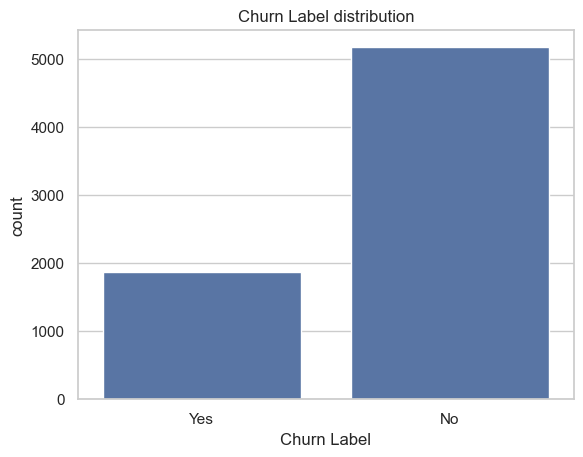

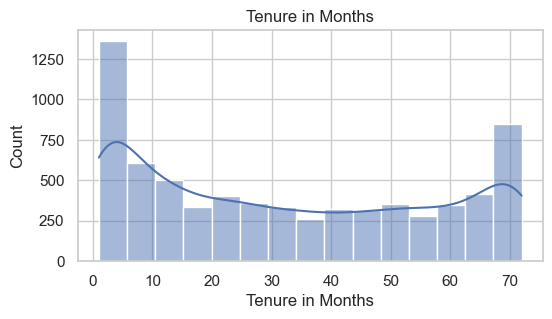

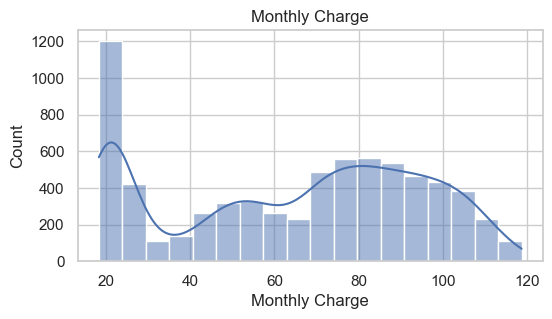

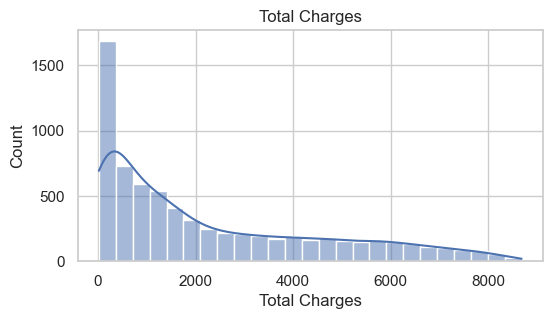

In [9]:
if 'Churn Label' in df.columns:
    sns.countplot(data=df, x='Churn Label')
    plt.title('Churn Label distribution')
    plt.show()

num_cols = [c for c in df.select_dtypes(include=np.number).columns if c in ['Monthly Charge','Total Charges','Tenure in Months']]
for c in num_cols:
    plt.figure(figsize=(6,3))
    sns.histplot(df[c].dropna(), kde=True)
    plt.title(c)
    plt.show()

## Feature engineering (explicit)

In [10]:
# tenure bucket
if 'Tenure in Months' in df.columns:
    df['tenure_months'] = df['Tenure in Months']
    df['tenure_bucket'] = pd.cut(df['tenure_months'], bins=[-1,1,12,24,48,1000], labels=['0-1','1-12','12-24','24-48','48+'])

# internet boolean
if 'Internet Service' in df.columns:
    df['has_internet'] = (~df['Internet Service'].isin(['No', 'None', None])).astype(int)

# map common Yes/No to binary columns
binary_map = {'Yes':1,'No':0,'yes':1,'no':0}
for col in ['Online Security','Online Backup','Device Protection Plan','Premium Tech Support','Streaming TV','Streaming Movies','Streaming Music','Unlimited Data','Phone Service','Multiple Lines']:
    if col in df.columns:
        df[col + '_bin'] = df[col].map(binary_map).fillna(0).astype(int)

print('Engineered columns sample:', [c for c in df.columns if c.endswith('_bin')][:10])

Engineered columns sample: ['Online Security_bin', 'Online Backup_bin', 'Device Protection Plan_bin', 'Premium Tech Support_bin', 'Streaming TV_bin', 'Streaming Movies_bin', 'Streaming Music_bin', 'Unlimited Data_bin', 'Phone Service_bin', 'Multiple Lines_bin']


## Prepare modelling dataset

In [11]:
# choose target
churn_candidates = [c for c in df.columns if 'churn' in c.lower()]
has_target = bool(churn_candidates)
if not has_target:
    print(f"No churn-like target found. Columns available (first 50): {list(df.columns)[:50]}")
    target = None
else:
    target = churn_candidates[0]
    print('Using target column:', target)
# drop identifiers and leakage columns
drop_cols = [c for c in df.columns if c.lower().strip() in ('customer id','customerid','customer')]
leak_cols = [c for c in df.columns if ('churn' in c.lower() and c != target) or c.lower().strip()=='customer status']
leak_cols = list(set(leak_cols))
print('Dropping leakage columns:', leak_cols)
if has_target:
    X = df.drop(columns=[target] + drop_cols + leak_cols)
    # map target to binary if needed
    if df[target].dtype == object:
        y = df[target].map({'Yes':1,'No':0})
    else:
        y = df[target]
else:
    # no target present; keep X for exploratory work and set y to None
    X = df.drop(columns=drop_cols + leak_cols)
    y = None
# quick reduction: drop very high-cardinality categoricals and one-hot encode the remainder
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()
high_card = [c for c in cat_cols if X[c].nunique() > 40]
X_small = X.drop(columns=high_card)
X_enc = pd.get_dummies(X_small, drop_first=True)
print('Final feature matrix shape:', X_enc.shape)

Using target column: Churn Label
Dropping leakage columns: ['Customer Status', 'Churn Score', 'Churn Reason', 'Churn Category']
Final feature matrix shape: (7043, 62)


## Train / evaluate models

In [12]:
if not (globals().get('has_target', False) and (y is not None)):
    print('No target column found — skipping train/evaluate section.')
else:
    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(X_enc, y, test_size=0.2, random_state=42, stratify=y)
    print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

    # logistic regression with explicit imputer+scaler
    imputer = SimpleImputer(strategy='median')
    scaler = StandardScaler()
    # fit imputer/scaler on numeric columns of the encoded frame (works on the numeric matrix)
    X_train_imp = imputer.fit_transform(X_train)
    X_test_imp = imputer.transform(X_test)
    X_train_scaled = scaler.fit_transform(X_train_imp)
    X_test_scaled = scaler.transform(X_test_imp)

    clf_lr = LogisticRegression(max_iter=1000)
    clf_rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)

    clf_lr.fit(X_train_scaled, y_train)
    clf_rf.fit(X_train.fillna(0), y_train)

    y_pred_lr = clf_lr.predict(X_test_scaled)
    y_prob_lr = clf_lr.predict_proba(X_test_scaled)[:,1]
    y_pred_rf = clf_rf.predict(X_test.fillna(0))
    y_prob_rf = clf_rf.predict_proba(X_test.fillna(0))[:,1]

    def summarize(y_true, y_pred, y_prob=None):
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        roc = roc_auc_score(y_true, y_prob) if y_prob is not None else np.nan
        return dict(accuracy=acc, precision=prec, recall=rec, f1=f1, roc_auc=roc)

    results = pd.DataFrame([summarize(y_test, y_pred_lr, y_prob_lr), summarize(y_test, y_pred_rf, y_prob_rf)], index=['LogisticRegression','RandomForest'])
    display(results)
    print('Confusion matrix (RF):')
    print(confusion_matrix(y_test, y_pred_rf))

    # save RandomForest as the example best model
    os.makedirs('artifacts', exist_ok=True)
    joblib.dump(clf_rf, 'artifacts/best_model.joblib')
    print('Saved artifacts/best_model.joblib')

Train shape: (5634, 62) Test shape: (1409, 62)


,accuracy,precision,recall,f1,roc_auc
LogisticRegression,0.963094,0.960000,0.898396,0.928177,0.992854
RandomForest,0.953868,0.978328,0.844920,0.906743,0.981854


Confusion matrix (RF):
[[1028    7]
 [  58  316]]
Saved artifacts/best_model.joblib
